### Imports

In [18]:
from collections import Counter
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Input
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from warnings import filterwarnings

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import numpy as np
import pickle
filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

### Loading and preprocessing the data

In [3]:
X_train, y_train, X_train_skel_features = None, None, None
with open("train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train, X_train_skel_features = data["data"], data["labels"], data["skel_features"]

X_test, y_test, X_test_skel_features = None, None, None
with open("test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test, X_test_skel_features = data["data"], data["labels"], data["skel_features"]

In [6]:
x_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
x_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape_cnn = (28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [10]:
def features(data):
    res = []
    
    res.append(list(map(len,data)))
    res.append(list(map(np.mean,data)))
    res.append(list(map(np.sum,data)))
    res.append(list(map(np.std,data)))
    res.append(list(map(lambda x: np.max(x) - np.min(x),data)))
    for i in range(0,110,10):
        res.append(list(map(lambda x: np.percentile(x, i),data)))

    point = lambda arrays, idx: map(lambda array: array[idx::8], arrays)    
    parsed = [list(point(data, i)) for i in range(8)]

    for i in range(8):
        res.append(list(map(len,parsed[i])))
        res.append(list(map(np.mean,parsed[i])))
        res.append(list(map(np.sum,parsed[i])))
        res.append(list(map(np.std,parsed[i])))
        res.append(list(map(lambda x: np.max(x) - np.min(x),parsed[i])))
        res.append(list(map(lambda x: Counter(x).most_common()[0][0], parsed[i])))
        res.append(list(map(lambda x: Counter(x).most_common()[0][1], parsed[i])))
        for j in range(0,110,10):
            res.append(list(map(lambda x: np.percentile(x, j),parsed[i])))
            
    return np.vstack(res).T

x_train_skel_features = features(X_train_skel_features)
x_test_skel_features = features(X_test_skel_features)
input_dim_skelet = (x_train_skel_features.shape[1],)

### f1 score

In [11]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Generate combined CNN

In [12]:
model_cnn_input = Input((28, 28, 1))
cnn = Conv2D(30, (3, 3), activation='relu', input_shape = input_shape_cnn)(model_cnn_input)
cnn = Conv2D(60, (3, 3), activation='relu')(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = BatchNormalization()(cnn) 
cnn = Activation('relu')(cnn)
cnn = Dropout(0.2)(cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(128, activation='relu')(cnn)

features_input = Input(input_dim_skelet)
features_layer1 = Dense(32, input_dim=input_dim_skelet)(features_input)

merged = Concatenate()([cnn, features_layer1])
layer1 = Dropout(0.5)(merged)
output_layer = Dense(num_classes, activation='softmax')(layer1)

model = Model(inputs=[model_cnn_input, features_input], outputs=output_layer)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy', f1])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 30)   300         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 24, 24, 60)   16260       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 60)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

### Fit

In [13]:
history = model.fit([x_train, x_train_skel_features], y_train,
          batch_size = 512,
          epochs = 10,
          verbose = 1,
          validation_data=([x_test, x_test_skel_features], y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 205s 3ms/step - loss: 12.5560 - acc: 0.2136 - f1: 0.2136 - val_loss: 10.9606 - val_acc: 0.3125 - val_f1: 0.3125
Epoch 2/10
60000/60000 [==============================] - 189s 3ms/step - loss: 8.1263 - acc: 0.4835 - f1: 0.4835 - val_loss: 4.5726 - val_acc: 0.7049 - val_f1: 0.7049
Epoch 3/10
60000/60000 [==============================] - 172s 3ms/step - loss: 3.1569 - acc: 0.7867 - f1: 0.7867 - val_loss: 0.7439 - val_acc: 0.9374 - val_f1: 0.9375
Epoch 4/10
60000/60000 [==============================] - 179s 3ms/step - loss: 0.8216 - acc: 0.9315 - f1: 0.9315 - val_loss: 0.3387 - val_acc: 0.9669 - val_f1: 0.9669
Epoch 5/10
60000/60000 [==============================] - 193s 3ms/step - loss: 0.5504 - acc: 0.9497 - f1: 0.9498 - val_loss: 0.2665 - val_acc: 0.9746 - val_f1: 0.9746
Epoch 6/10
60000/60000 [==============================] - 188s 3ms/step - loss: 0.4179 - acc: 0.9583 - f1: 0

### Score

In [16]:
score = model.evaluate([x_test, x_test_skel_features], y_test, verbose=0)

print(f'Loss: {score[0]: 0.5f}')
print(f'Accuracy:{score[1]*100: 0.2f}%')
print(f'F1_score:{score[2]: 0.5f}')

Loss:  0.09156
Accuracy: 98.49%
F1_score: 0.98510


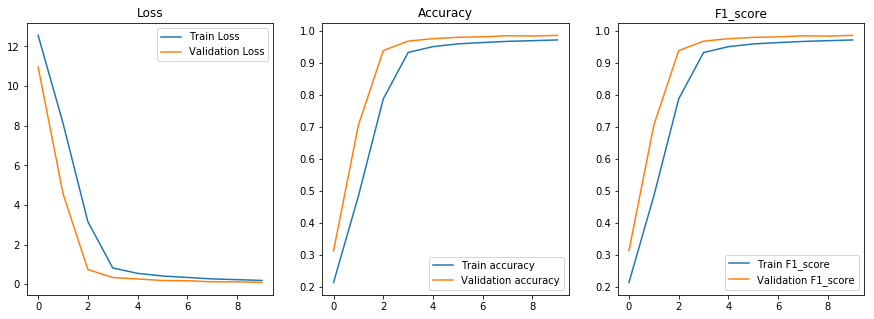

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["acc"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax[2].set_title('F1_score')
ax[2].plot(history.epoch, history.history["f1"], label="Train F1_score")
ax[2].plot(history.epoch, history.history["val_f1"], label="Validation F1_score")
ax[0].legend()
ax[1].legend()
ax[2].legend()